In [71]:
### Scrape game info to find HR totals for each field

import requests
from bs4 import BeautifulSoup
from tqdm import tqdm

In [72]:


# Load the webpage
url = "https://www.warrennolan.com/baseball/2023/ncaa-regionals"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find all tables in the webpage
tables = soup.find_all('tbody')

games = []

# Loop over each table
for table in tables:
    # Find all game rows in each table
    game_rows = table.find_all('tr')

    # Loop over each game row
    for row in game_rows:
        game_cells = row.find_all('td', {'class': 'data-cell'})
        
        # Check if the row is a game row
        if game_cells and "Game" in game_cells[0].text:
            game = {}

            # Game number
            game['game_number'] = game_cells[0].text.strip()

            # Team 1 name and score
            team_1 = game_cells[2].find('div', {'class': 'name-subcontainer'}).text.strip()
            score_1 = game_cells[3].text.strip()

            # Team 2 name and score
            team_2 = game_cells[5].find('div', {'class': 'name-subcontainer'}).text.strip()
            score_2 = game_cells[4].text.strip()

            game['team_1'] = team_1
            game['score_1'] = score_1
            game['team_2'] = team_2
            game['score_2'] = score_2

            games.append(game)




In [73]:
import pandas as pd

# Assuming the 'games' variable is a list of dictionaries obtained from the previous step

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(games)

# Now, let's add the region numbers. We'll assume that each region is represented by one table on the webpage.
# Therefore, we can simply increment the region number after each table.

region_number = 1
for i in range(len(df)):
    # Check if it's a new game number, which would indicate a new region
    if df.iloc[i]['game_number'] == 'Game 1':
        region_number += 1
    df.loc[i, 'region_id'] = region_number

# Now, the 'df' DataFrame should contain all the game data with an additional 'region_number' column.
# You can view the first few rows of the DataFrame with the following command:
df.head()


,game_number,team_1,score_1,team_2,score_2,region_id
0,Game 1,Samford,4,Southern Miss,2,2.0
1,Game 2,Penn,6,Auburn,3,2.0
2,Game 3,Southern Miss,7,Auburn,2,2.0
3,Game 4,Penn,5,Samford,4,2.0
4,Game 5,Southern Miss,9,Samford,4,2.0


## Scrapping espn for box score and stats

In [74]:
### ESPN Baseball Stats

base_url = 'https://www.espn.com/college-baseball/scoreboard/_/date/'

## Date Format: YYYMMDD
# Dates interested in 20230602 until present

# Not all day will have games. Will probably return 404 error
# Want to get the data for each game
# the main thing I am interested in is the home runs hit by each team and the location of the game



In [75]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from datetime import timedelta, date

# Helper function to generate dates
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

# Start and end dates
start_date = date(2023, 6, 2)
end_date = date.today()  # today's date

base_url = 'https://www.espn.com/college-baseball/scoreboard/_/date/'
game_data = []  # this list will hold our game data

# Loop over each date
for single_date in tqdm(daterange(start_date, end_date)):
    url = base_url + single_date.strftime("%Y%m%d")
    
    # Try accessing the page
    try:
        response = requests.get(url)
        response.raise_for_status()  # raise exception if invalid response
    except (requests.HTTPError, requests.ConnectionError):
        # Handle the exception if it occurs
        print(f"No data for {single_date.strftime('%Y-%m-%d')}")
        continue

    soup = BeautifulSoup(response.text, 'html.parser')

    # Find all game sections
    game_sections = soup.find_all('section', class_='Scoreboard bg-clr-white flex flex-auto justify-between')

    # For each game section, get the required data
    for section in game_sections:
        game = {}
        
        # Find the link to the box score and extract the game Id
        box_score_link = section.find('a', text='Box Score')
        if box_score_link is not None:
            game['game_id'] = box_score_link['href'].split('/')[-1]

        game_info = section.find('div', class_='ScoreboardScoreCell__Note clr-gray-04 n9 w-auto ml0')
        if game_info is not None:
            game['game_info'] = game_info.text
            
        game_run_elements = section.find_all('div', class_='ScoreboardScoreCell__Value flex justify-center pl2 baseball')
        if game_run_elements is not None and len(game_run_elements) >= 4:  # 4 because we have runs, hits, and errors for both teams
            game['away_team_runs'] = game_run_elements[0].text
            game['home_team_runs'] = game_run_elements[3].text

        # Add game data to the list
        game_data.append(game)

# Convert the list of games to a DataFrame
df = pd.DataFrame(game_data)

# Print DataFrame
# print(df)


24it [00:09,  2.60it/s]


In [76]:
# clean up the game infor column to just have the name of the site
# Goal, drop everything but the site name. should end up with 16 unique values
# strip NCAA Baseball Championship - Regionals from the game_info column
df['game_info'] = df['game_info'].str.replace('NCAA Baseball Championship -', '')

# find Regional or Super  and drop everything after that
df['game_info'] = df['game_info'].str.split('Regional').str[0]
df['game_info'] = df['game_info'].str.split('Super').str[0]




# strip the leading and trailing whitespace
df['game_info'] = df['game_info'].str.strip()



In [77]:
df.head()

# len(df['game_info'].unique())

# print a url for the box score
# df['box_score_link'].head()

# give me some sample links to look at
# df['box_score_link'].sample(10)


# are any null?
df['away_team_runs'].isnull().sum()
df['home_team_runs'].isnull().sum()


# ADD UP ALL THE RUN SCORED IN EACH GAME AND AT EACH SITE
# drop null scores
df = df.dropna(subset=['away_team_runs', 'home_team_runs'])
df['away_team_runs'] = df['away_team_runs'].astype(int)
df['home_team_runs'] = df['home_team_runs'].astype(int)

df['total_runs'] = df['away_team_runs'] + df['home_team_runs']
df.head()

# find number of runs scored at each site and runs per game
df.groupby('game_info')['total_runs'].agg(['sum', 'mean']).sort_values(by='sum', ascending=False)

# Count of the sites
df['game_info'].value_counts()

# number of sites
len(df['game_info'].unique())





25

In [78]:
df.head()

,game_id,game_info,away_team_runs,home_team_runs,total_runs
0,401551019,Winston-Salem,0,12,12
1,401551049,Fayetteville,6,13,19
2,401551027,Baton Rouge,2,7,9
3,401551041,Charlottesville,1,15,16
4,401551023,Coral Gables,1,9,10


## working above

In [79]:
## Dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import seaborn as sns


In [80]:
# ## Test Block to correctly get the home runs for each team

# # get the box score for the first game
# url = 'https://www.espn.com/college-baseball/boxscore/_/gameId/401551019'

# results = pd.read_html(url)

# print(results[9]['HR'])

# # get the last value from reults[3]['HR']
# # this is the home runs for the home team
# results[3]['HR'].iloc[-1]

In [81]:
# print(results[5]['HR'].iloc[-1])

In [82]:
base_game_url = 'https://www.espn.com/college-baseball/boxscore/_/gameId/'

import pandas as pd

# List of urls
urls = [base_game_url + game_id for game_id in df['game_id']]

# Create an empty dataframe to store the results
results = pd.DataFrame(columns=['team_1', 'team_2', 'runs_1', 'hits_1', 'errors_1', 'home_runs_1', 'runs_2', 'hits_2', 'errors_2', 'home_runs_2'])

for url in tqdm(urls):
    tables = pd.read_html(url)

    # The second table contains the data we're interested in
    score_table = tables[1]

    # The team names are in the first table
    team_table = tables[0]
    team_1 = team_table.iloc[0, 0]
    team_2 = team_table.iloc[1, 0]

    # Extract the runs, hits, and errors for each team
    runs_1, hits_1, errors_1 = score_table.iloc[0, -3:]
    runs_2, hits_2, errors_2 = score_table.iloc[1, -3:]

    # The team's home runs are in tables 3 and 9
    # Convert the 'HR' column to numeric before summing
    home_runs_1 = pd.to_numeric(tables[3]['HR'].iloc[-1])  # Sum the HR column for team 1
    home_runs_2 = pd.to_numeric(tables[5]['HR'].iloc[-1])  # Sum the HR column for team 2
    home_runs = home_runs_1 + home_runs_2

    # Add the results to the results dataframe
    results = results.append({
        'team_1': team_1, 'team_2': team_2,
        'runs_1': runs_1, 'hits_1': hits_1, 'errors_1': errors_1, 'home_runs_1': home_runs_1,
        'runs_2': runs_2, 'hits_2': hits_2, 'errors_2': errors_2, 'home_runs_2': home_runs_2, 
        'home_runs': home_runs,
    }, ignore_index=True)

# Now results is a dataframe with the runs, hits, errors, and home runs for each team in each game
# print(results)


  0%|          | 0/138 [00:00<?, ?it/s]C:\Users\Justin\AppData\Local\Temp\ipykernel_10956\1781235175.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
  1%|          | 1/138 [00:00<01:26,  1.59it/s]C:\Users\Justin\AppData\Local\Temp\ipykernel_10956\1781235175.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
  1%|▏         | 2/138 [00:01<01:13,  1.84it/s]C:\Users\Justin\AppData\Local\Temp\ipykernel_10956\1781235175.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
  2%|▏         | 3/138 [00:01<01:10,  1.92it/s]C:\Users\Justin\AppData\Local\Temp\ipykernel_10956\1781235175.py:33: FutureWarning: The frame.append method is deprecated and w

In [83]:
# Merge the results with the original dataframe
df = df.merge(results, left_index=True, right_index=True)



# Print the dataframe
# print(df)

# Save the dataframe to a csv file
df.to_csv('NCAA_GAME_DATA.csv', index=False)


In [84]:
## load The data
df = pd.read_csv('NCAA_GAME_DATA.csv')

In [85]:
## Open data frame with the parameters like color1 and color2
import pandas as pd
import os

params_df = pd.read_csv('data/NCAA_D1/NCAA_regional_sites.csv')

# params_df.head(30)

In [86]:
## Find all rows with "College World Series" in the game_info column and rename them CWS (Omaha)

if df['game_info'].str.contains('College World Series').any():
    df.loc[df['game_info'].str.contains('College World Series'), 'game_info'] = 'OMAHA'



In [87]:
## Calculate how many games were played at each site
# df['game_info'].value_counts()
# df['game_info'].value_counts().sum()





In [88]:
df.head()

# show the total number of home runs hit at each site
df.groupby('game_info')['home_runs'].sum().sort_values(ascending=False)



game_info
Stanford           31.0
Baton Rouge        27.0
Stillwater         25.0
Conway             25.0
Gainesville        24.0
OMAHA              24.0
Winston-Salem      23.0
Nashville          22.0
Eugene             21.0
Charlottesville    21.0
Tuscaloosa         19.0
Auburn             19.0
Clemson            18.0
Lexington          17.0
Coral Gables       16.0
Terre Haute        16.0
Fayetteville       15.0
Columbia           14.0
Hattiesburg        12.0
Fort Worth          7.0
Name: home_runs, dtype: float64

In [89]:
## Calculate how many games were played at each site
# df.head()


# Group by the site add a column for the number of games at the site and sum the runs, hits, and home runs 
by_site_df = df.groupby('game_info')['total_runs', 'home_runs'].sum().sort_values(by='total_runs', ascending=False)

# Add a column for the number of games at the site
by_site_df['games'] = df['game_info'].value_counts()

## Add the school colors to the dataframe
by_site_df = by_site_df.merge(params_df, on='game_info')

# Calculate per game stats
# by_site_df['home_runs'] = by_site_df['home_runs1'] + by_site_df['home_runs2']
by_site_df['runs_per_game'] = (by_site_df['total_runs'] / by_site_df['games']).round(0)
# by_site_df['hits_per_game'] = (by_site_df['hits'] / by_site_df['games']).round(2)
by_site_df['home_runs_per_game'] = (by_site_df['home_runs'] / by_site_df['games']).round(2)

# by_site_df.head()





C:\Users\Justin\AppData\Local\Temp\ipykernel_10956\2122749904.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_site_df = df.groupby('game_info')['total_runs', 'home_runs'].sum().sort_values(by='total_runs', ascending=False)


In [90]:
# by_site_df.head(30)

In [91]:
# Copy the game info column with host school to a new column with that name so I don't have to change the plotting code

# by_site_df['host_school'] = by_site_df.index

by_site_df.head()

df = by_site_df



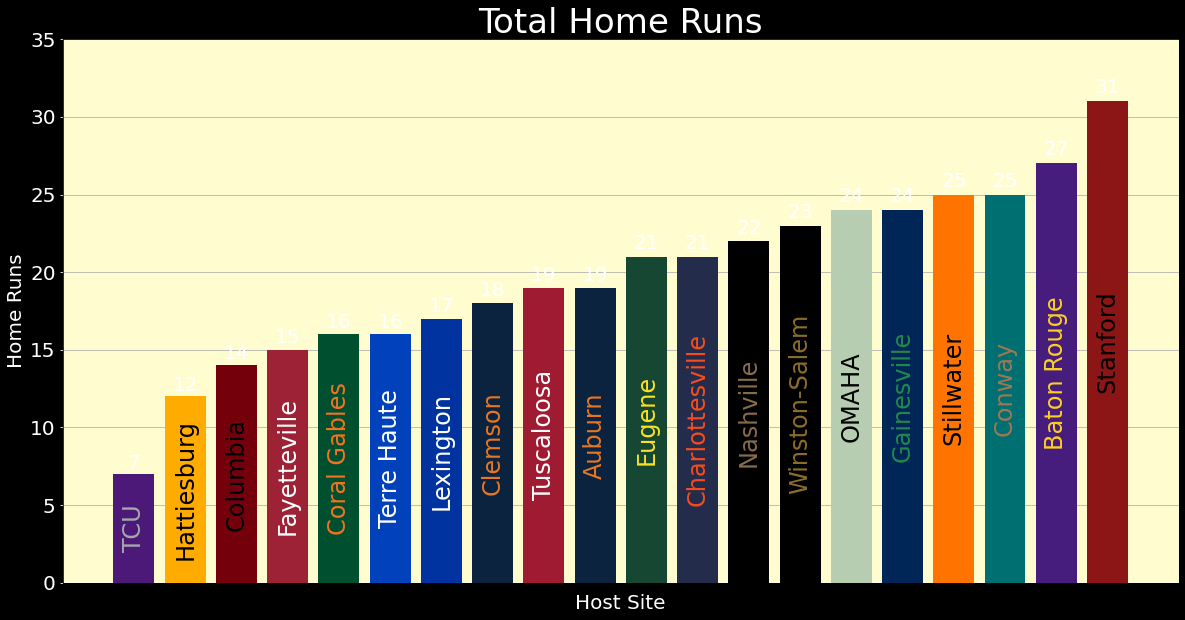

In [92]:
import matplotlib.pyplot as plt

# import a color library that can deal with the hex colors in my dataframe
import matplotlib.colors as mcolors



# Make a plot of the total home runs hit at each ballpark
# Specify your desired background color
background_color = '#FFFDD0'

# # Drop rows with NaN values in 'host_school' column
# df = df.dropna(subset=['host_school'])
# # Drop rows with NaN values in 'home_runs' column
# df = df.dropna(subset=['home_runs'])

# # Convert 'host_school' column to string
df['host_school'] = df['host_school'].astype(str)

# Change Texas Christian to TCU so it displays better on the plot
df['host_school'] = df['host_school'].replace('Fort Worth', 'TCU')
## Change the game info column to since that is being used for the x-axis labels
df['game_info'] = df['game_info'].replace('Fort Worth', 'TCU')

# Change Southern Miss to So. Miss so it displays better on the plot
df['host_school'] = df['host_school'].replace('Southern Miss', 'So. Miss')

# Sort values for better visualization
df = df.sort_values(by='home_runs')

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(20,10))
# Put a grid on the plot
ax.grid(True, which='major', axis='y')
ax.set_axisbelow(True) # make sure grid is behind bars


# Create a bar plot
bars = ax.bar(df['host_school'], df['home_runs'], color=df['color1'])

# Change the background color of the plot and the figure
fig.set_facecolor('black')
ax.set_facecolor(background_color)



# Hide x-axis labels
ax.set_xticklabels([])

# Hid the tick marks on the x-axis
plt.tick_params(axis='x', which='both', bottom=False)

# Annotate bars with 'host_school' vertically centered and light grey as  the text color
for bar, school_name, text_color in zip(bars, df['game_info'], df['color2']):
    ax.annotate(school_name, 
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2), 
                ha='center', 
                va='center',
                color=text_color,
                rotation=90, # to make text vertical
                fontsize=24) 

# add the value at the top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., 1.01*height, '%.0f' % height, ha='center', va='bottom', color='white', fontsize=20)

# Set the y limit
ax.set_ylim([0, 35])

# Set labels
ax.set_xlabel('Host Site')
ax.set_ylabel('Home Runs')

# Set title
ax.set_title('Total Home Runs')
# adjust the font sizes
ax.title.set_fontsize(34)
# y-axis label
ax.yaxis.label.set_fontsize(24)

# Optional: rotate x-axis labels if they overlap
plt.xticks(rotation=90)

#change the text color to white for the x and y axis and labels
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white', labelsize=20)
ax.tick_params(axis='y', colors='white', labelsize=20)

# Change font size for x and y axis labels
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
# Add a grid





# Save the plot before showing it, create the directory if it doesn't exist
output_dir = 'data/NCAA_D1/assests/graphs/TEMP/stack'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
plt.savefig('data/NCAA_D1/assests/graphs/TEMP/stack/home_runs_by_park.png')

# Then you can show the plot
plt.show()



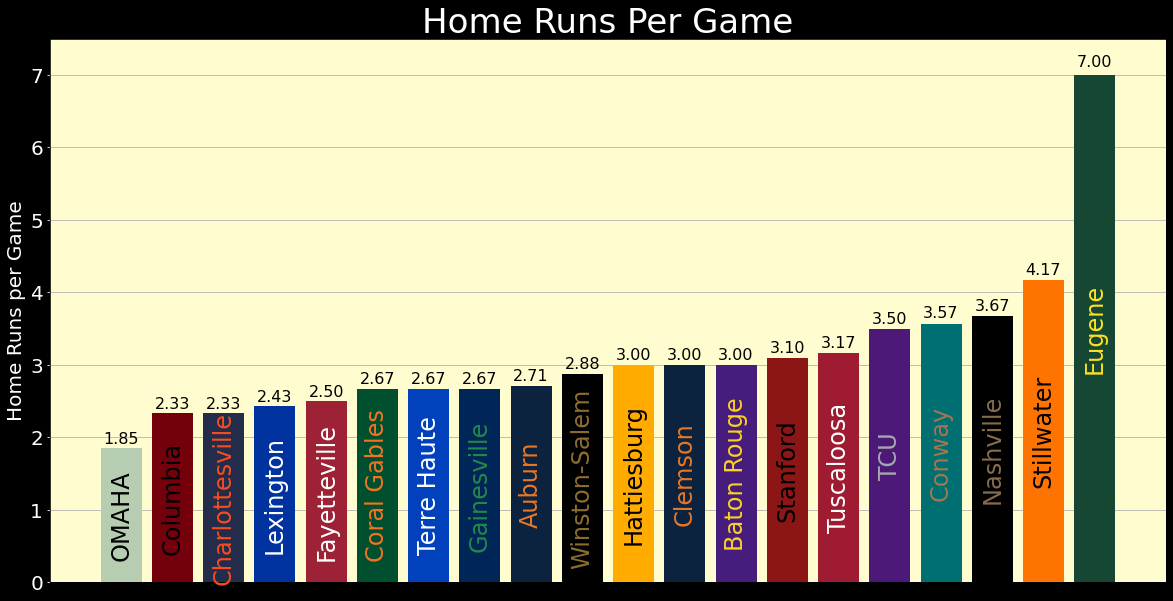

In [93]:
# Make a plot of the total home runs hit at each ballpark
# order from greatest to smallest

# Drop rows with NaN values in 'host_school' column
df = df.dropna(subset=['host_school'])

# Convert 'host_school' column to string
df['host_school'] = df['host_school'].astype(str)

## Abrev Wake Forrect and Coastal Carloina to C. Carolina and Wake For.
df['host_school'] = df['host_school'].str.replace('Wake Forest', 'Wake For.')
df['host_school'] = df['host_school'].str.replace('Coastal Carolina', 'C. Carolina')
df['host_school'] = df['host_school'].str.replace('South Carolina', 'S. Carolina')

# Specify your desired background color
# background_color = '#f6e8b1'



# Sort values for better visualization
df = df.sort_values(by='home_runs_per_game')

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(20,10))

# Create a bar plot
bars = ax.bar(df['host_school'], df['home_runs_per_game'], color=df['color1'])

# Change the background color of the plot and the figure
ax.set_facecolor(background_color)
fig.set_facecolor('black')

# Hide x-axis labels
ax.set_xticklabels([])

# Hid the tick marks on the x-axis
plt.tick_params(axis='x', which='both', bottom=False)

# Annotate bars with 'host_school' vertically centered and light grey as  the text color
for bar, school_name, text_color in zip(bars, df['game_info'], df['color2']):
    ax.annotate(school_name, 
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2), 
                ha='center', 
                va='center',
                color=text_color,
                rotation=90, # to make text vertical
                fontsize=24) 

# Put a grid on the plot
ax.grid(True, which='major', axis='y')
ax.set_axisbelow(True) # make sure grid is behind bars

# add the value at the top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., 1.01*height, '%.2f' % height, ha='center', va='bottom',
    fontsize=16)


# Set the y limit
ax.set_ylim([0, 7.5])

## Set the title
ax.set_title('Home Runs Per Game')

# Set labels
# ax.set_xlabel('Host Site')
ax.set_ylabel('Home Runs per Game')
# adjust the font size


# adjust the font sizes
ax.title.set_fontsize(34)
# y-axis label
ax.yaxis.label.set_fontsize(24)

# Optional: rotate x-axis labels if they overlap
plt.xticks(rotation=90)

ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white', labelsize=20)
ax.tick_params(axis='y', colors='white', labelsize=20)
# Move the x-axis label to the other side of the axis
# ax.xaxis.set_label_position('top')
# ax.xaxis.tick_top()

# Change font size for x and y axis labels
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)



# Save the plot before showing it
plt.savefig('data/NCAA_D1/assests/graphs/TEMP/stack/home_runs_per_game.png')

# Then you can show the plot
plt.show()

In [94]:
### Stack the two plots and output a png file

## cREATE COMPOSITE GRAPH OF HOME RUNS AND HOME RUNS PER GAME
from PIL import Image

# Load the two images
image2 = Image.open('data/NCAA_D1/assests/graphs/TEMP/stack/home_runs_by_park.png')
image1 = Image.open('data/NCAA_D1/assests/graphs/TEMP/stack/home_runs_per_game.png')


# Get the maximum width and the total height
max_width = max(image1.width, image2.width)
total_height = image1.height + image2.height

# Create a new, blank image with the correct size
new_image = Image.new('RGB', (max_width, total_height))

# Paste image1 and image2 onto the new image
new_image.paste(image2, (0, 0))
new_image.paste(image1, (0, image1.height))

# Save the new image, create the directory if it doesn't exist
output_dir = 'data/NCAA_D1/assests/graphs/TEMP/output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

new_image.save('data/NCAA_D1/assests/graphs/TEMP/output/bar_graph.png')
